In [1]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os
import torch.nn.functional as F
import albumentations

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataloader

In [4]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (384, 384))
    label = np.array(self.one_hot_label[self.list_labels[idx]]) # .astype('float')

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)

    image = image.transpose(2, 0, 1)
    sample = (image, label)

    return sample # image, label

In [5]:
def get_transforms(image_size=(224, 224)):

    transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        albumentations.Normalize(),
        albumentations.RandomBrightnessContrast(p=0.2),
    ])

    transforms_val = albumentations.Compose([
        # albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [6]:
transforms_train, transforms_val = get_transforms(image_size=(224, 224))

In [7]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms_train)
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms_val)

In [8]:
train_data_loader = DataLoader(transformed_train_data, batch_size=16, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=16, shuffle=True)

# ResNet 

In [9]:
# Original code: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

import torch.nn as nn
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes, bottleneck=False):
        super(ResNet, self).__init__()        
        blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
        layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
        assert layers[depth], 'invalid detph for ResNet (depth should be one of 18, 34, 50, 101, 152, and 200)'

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(blocks[depth], 64, layers[depth][0])
        self.layer2 = self._make_layer(blocks[depth], 128, layers[depth][1], stride=2)
        self.layer3 = self._make_layer(blocks[depth], 256, layers[depth][2], stride=2)
        self.layer4 = self._make_layer(blocks[depth], 512, layers[depth][3], stride=2)
        self.avgpool = nn.AvgPool2d(7) 
        self.fc = nn.Linear(512 * blocks[depth].expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        # normalize 
#         x = F.normalize(x)
        x = self.fc(x) # / 0.08
    
        return x

# Train 

In [10]:


'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            torch.save(model.state_dict(), "save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))
            print("[INFO] save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

# Run 

In [11]:
model = ResNet(18, 2).to(device)

In [12]:
def init_weights(net):
    """the weights of conv layer and fully connected layers 
    are both initilized with Xavier algorithm, In particular,
    we set the parameters to random values uniformly drawn from [-a, a]
    where a = sqrt(6 * (din + dout)), for batch normalization 
    layers, y=1, b=0, all bias initialized to 0.
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    return net

In [13]:
model = init_weights(model)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.8301062626838684, Valid_loss: 0.70257169008255, Train_accuracy: 56.99999999999999, Valid_accuracy: 61.0
[INFO] save_model/epoch_0_acc61.0.pth
Epochs: 1, Train_loss: 0.6991676993370056, Valid_loss: 0.6548188077776056, Train_accuracy: 58.550000000000004, Valid_accuracy: 60.16666666666667
[INFO] save_model/epoch_1_acc60.16666666666667.pth
Epochs: 2, Train_loss: 0.6908676228523254, Valid_loss: 0.9386058277205417, Train_accuracy: 56.00000000000001, Valid_accuracy: 52.83333333333333
[INFO] save_model/epoch_2_acc52.83333333333333.pth
Epochs: 3, Train_loss: 0.68577734375, Valid_loss: 0.7257592207507083, Train_accuracy: 49.65, Valid_accuracy: 50.5
[INFO] save_model/epoch_3_acc50.5.pth
Epochs: 4, Train_loss: 0.7192531189918518, Valid_loss: 0.7376879853637595, Train_accuracy: 50.3, Valid_accuracy: 50.83333333333333
[INFO] save_model/epoch_4_acc50.83333333333333.pth
Epochs: 5, Train_loss: 0.6947514233589173, Valid_loss: 0.689477770736343, Train_accuracy: 60.25, Valid_accur

/tmp/ipykernel_28/2194894264.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


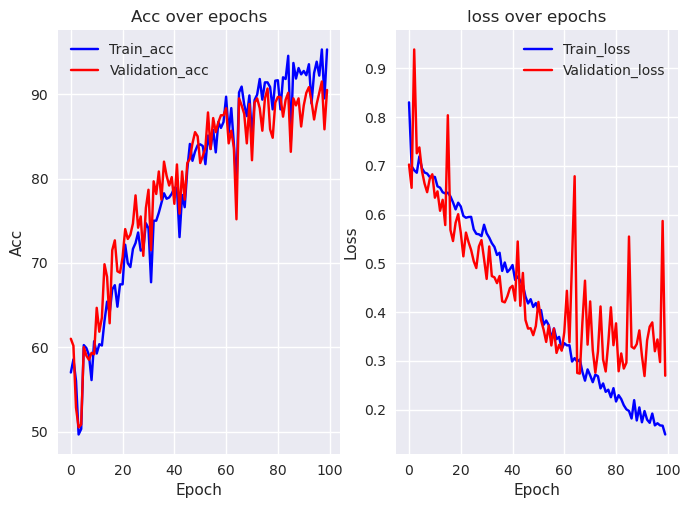

In [15]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 100, device)